---
## Step 0: Load The Data

In [10]:
# Import libraries
#import pickle
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import tensorflow as tf
#from tensorflow.contrib.layers import flatten
import os
import glob
import pandas as pd
import re
%matplotlib inline

In [2]:
img_list = glob.glob('./rec_images/*.jpeg')

In [8]:
img = cv2.imread(img_list[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

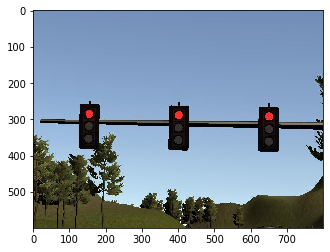

In [9]:
#plt.figure()
plt.imshow(img)